# LSTM and Learning Rate sweep on Synthetic Time Series Dataset from Week 1:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%203%20Lesson%204%20-%20LSTM.ipynb

LSTM Andrew Ng:  https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay


- RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
- Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.
- RNN only outputs the last sequence (last time step) by default, if we want to get the output for all the sequences (all time steps) to feed it into a lower RNN, we need to use return_sequences=True.
- RNN use 'tanh' as activation function by default.
- Simple RNN use the output as the state vector recurred (fed back) to the next time step.
- LSTM carry a cell state from step 0 to the end time step in order that initial information has bigger impact on latter time steps than on the simple RNN.
- Bidirectional then carries info from 0 to end and then from end to 0.


Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [0]:
# Creating a synthetic Time Series:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Spliting the data into Training and Validation sets:

time_split = 1000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 20  # window_size is the number of features!
batch_size = 128
shuffle_buffer_size = 1000

# LSTM Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=50, verbose=1)

Epoch 1/50
8/8 [==============================] - 0s 44ms/step - loss: 20.5884 - mae: 21.0998 - mse: 714.4336
Epoch 2/50
8/8 [==============================] - 0s 39ms/step - loss: 17.0255 - mae: 17.5018 - mse: 482.1877
Epoch 3/50
8/8 [==============================] - 0s 38ms/step - loss: 15.1270 - mae: 15.6166 - mse: 367.9992
Epoch 4/50
8/8 [==============================] - 0s 39ms/step - loss: 14.3808 - mae: 14.8615 - mse: 324.9096
Epoch 5/50
8/8 [==============================] - 0s 39ms/step - loss: 13.8904 - mae: 14.4083 - mse: 302.8612
Epoch 6/50
8/8 [==============================] - 0s 40ms/step - loss: 13.4756 - mae: 13.9747 - mse: 286.2751
Epoch 7/50
8/8 [==============================] - 0s 41ms/step - loss: 13.1097 - mae: 13.5630 - mse: 273.2038
Epoch 8/50
8/8 [==============================] - 0s 37ms/step - loss: 12.6187 - mae: 13.1191 - mse: 259.5216
Epoch 9/50
8/8 [==============================] - 0s 39ms/step - loss: 12.2135 - mae: 12.7058 - mse: 249.6636
Epoch 10/5

1441
[array([[50.182026]], dtype=float32), array([[51.07097]], dtype=float32)]


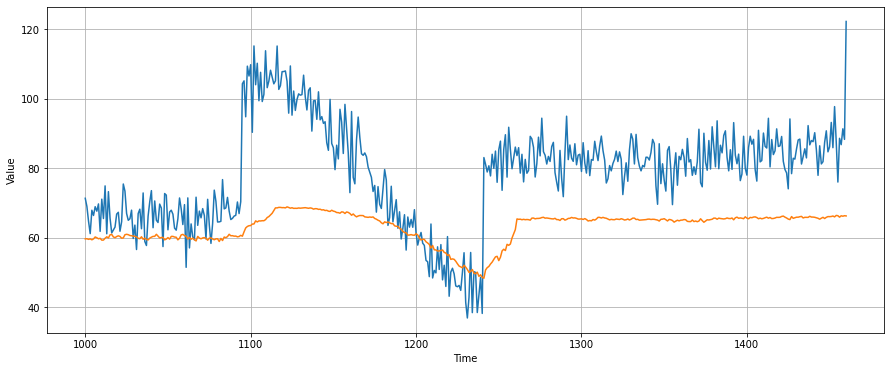

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

381.54706
16.381628


# LSTM with learning rate sweep:

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(train_dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 40ms/step - loss: 21.6787 - mae: 22.1120 - mse: 774.6852 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 21.6511 - mae: 22.0553 - mse: 771.1689 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 37ms/step - loss: 21.5323 - mae: 21.9635 - mse: 765.6108 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 21.3351 - mae: 21.8526 - mse: 758.9479 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 38ms/step - loss: 21.2402 - mae: 21.7241 - mse: 751.2225 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 21.1149 - mae: 21.5810 - mse: 742.4758 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 36ms/step - loss: 21.0180 - mae: 21.4234 - mse: 732.8007 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 36ms/step - loss: 20.7420 - mae: 21.2542 - mse: 72

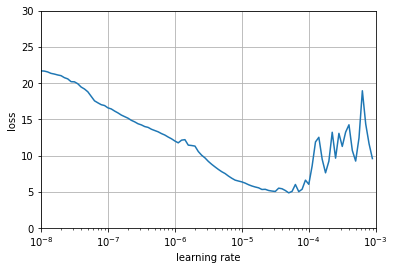

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 30])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the LSTM with the best Learning Rate

In [0]:
tf.keras.backend.clear_session()  # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
# Since our dataset is 2D [batch_size, window_size], we'll have to expand it using Lambda as first layer.

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))  # we use the Lambda-function layer to expand the dataset (originally 2D) into the needed 3D dimension
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)))  # if we don't use the lambda layer, we should put this: model.add(tf.keras.layers.LSTM(10, activation='relu', input_shape=[None, 1]))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))  # remember to add return_sequences=True if you want to output for each time step and not just the last one!!! This is if you want to add another LSTM, GRU or RNN underneath.
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!
model.add(tf.keras.layers.Lambda(lambda x : x * 100.0))   # this scales the output for making it more similar values to the training features -> trains better!

model.summary()

# model.compile(optimizer= tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.
# Using the Huber Loss Function:
model.compile(optimizer= tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mae','mse'])  # we use stochastic gradient descent as optimizer and 'Huber' as loss function.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(train_dataset, epochs=400, verbose=1)

Epoch 1/400
8/8 [==============================] - 0s 38ms/step - loss: 15.3403 - mae: 15.9281 - mse: 396.9150
Epoch 2/400
8/8 [==============================] - 0s 37ms/step - loss: 9.5397 - mae: 10.0769 - mse: 182.5926
Epoch 3/400
8/8 [==============================] - 0s 37ms/step - loss: 7.0853 - mae: 7.5532 - mse: 118.0282
Epoch 4/400
8/8 [==============================] - 0s 39ms/step - loss: 6.0636 - mae: 6.5775 - mse: 85.8163
Epoch 5/400
8/8 [==============================] - 0s 38ms/step - loss: 5.7313 - mae: 6.2401 - mse: 77.7764
Epoch 6/400
8/8 [==============================] - 0s 38ms/step - loss: 5.4379 - mae: 5.9258 - mse: 71.3224
Epoch 7/400
8/8 [==============================] - 0s 38ms/step - loss: 6.5506 - mae: 6.9663 - mse: 84.5650
Epoch 8/400
8/8 [==============================] - 0s 37ms/step - loss: 6.6918 - mae: 7.1615 - mse: 92.7959
Epoch 9/400
8/8 [==============================] - 0s 39ms/step - loss: 7.2349 - mae: 7.8504 - mse: 102.3169
Epoch 10/400
8/8 [===

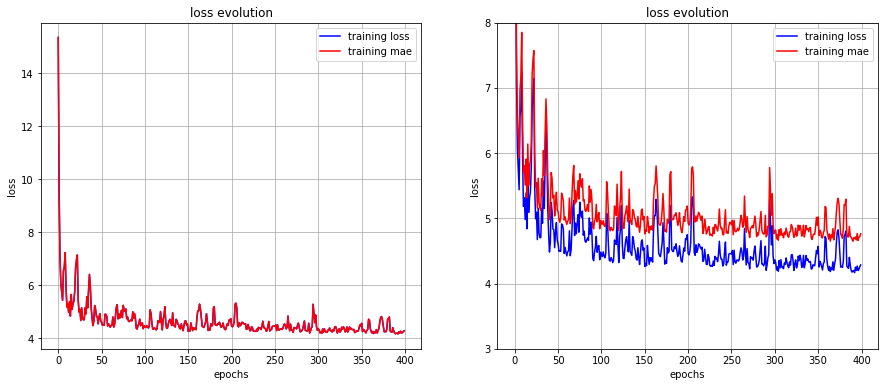

In [0]:
loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(mae, 'r', label='training mae')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((3, 8))
plt.title('loss evolution')
plt.legend()

plt.show()

1441
[array([[41.597393]], dtype=float32), array([[44.985043]], dtype=float32)]


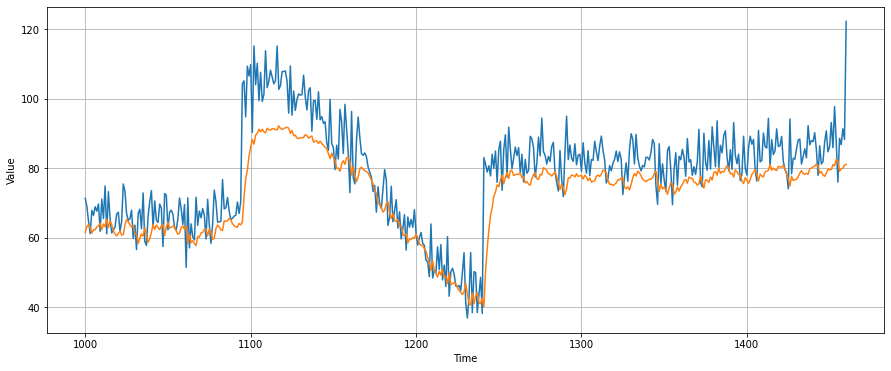

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

88.8867
7.168099
